+ random transforms
+ thread-safe gens
+ 128x128 images
+ extra dense layer

In [1]:
RUN = 'E'
RND = 777

In [2]:
IMAGES_DIR = '/d2/caches/kaggle-planet/processed-images-128x128'
IMAGE_SHAPE = (128, 128, 4)

TRAIN_BATCH_SIZE = 53
TRAIN_EPOCHS = 100

VAL_SPLIT = 0.2

VAL_BATCH_SIZE = 16

TENSORBOARD_DIR = '/tensorboard/planet/' + RUN
MODEL_CHECKPOINT_DIR = '/d2/caches/kaggle-planet/models/' + RUN

In [3]:
%run 'Lib.ipynb'

MODEL_CHECKPOINT_DIR not defined 


Using TensorFlow backend.


In [4]:
import keras
from keras.layers import *
from keras.applications import *
from keras.models import *
from keras.callbacks import *

In [5]:
# load data
X_files = np.load('out/X_files.npy')
Y_tags_misc = np.load('out/Y_tags_misc.npy')
Y_tags_weather = np.load('out/Y_tags_weather.npy')

In [6]:
# split data into tran/val sets
from sklearn.model_selection import train_test_split

X_files_train, X_files_val, \
Y_tags_misc_train, Y_tags_misc_val, \
Y_tags_weather_train, Y_tags_weather_val = \
train_test_split(
    X_files,
    Y_tags_misc,
    Y_tags_weather,
    test_size=VAL_SPLIT,
    random_state=RND)

In [7]:
# calculate samples per epoch so that epoch can consist of integer number of batches
TRAIN_SAMPLES_PER_EPOCH = int(len(X_files_train) / TRAIN_BATCH_SIZE) * TRAIN_BATCH_SIZE
print ('Samples per epoch (train):', TRAIN_SAMPLES_PER_EPOCH, 'of', len(X_files_train))

Samples per epoch (train): 32383 of 32383


In [8]:
# calculate samples per epoch so that epoch can consist of integer number of batches
VAL_SAMPLES_PER_EPOCH = int(len(X_files_val) / VAL_BATCH_SIZE) * VAL_BATCH_SIZE
print ('Samples per epoch (val):', VAL_SAMPLES_PER_EPOCH, 'of', len(X_files_val))

Samples per epoch (val): 8096 of 8096


In [9]:
# define model
image_input = Input(shape=IMAGE_SHAPE, name='image_input')

x = Conv2D(32, (3, 3), padding='same', activation='relu')(image_input)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)

x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)

x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)

x = Flatten()(x)
x = Dropout(rate=0.5)(x)

x = Dense(512, activation='relu')(x)
features = Dropout(rate=0.5)(x)

out_tags_misc = Dense(Y_tags_misc.shape[1], activation='sigmoid', name='tags_misc')(features)
out_tags_weather = Dense(Y_tags_weather.shape[1], activation='softmax', name='tags_weather')(features)

model = Model(inputs=[image_input], outputs=[out_tags_misc, out_tags_weather])

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_input (InputLayer)         (None, 128, 128, 4)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 128, 32)  1184        image_input[0][0]                
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 128, 128, 32)  9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 64, 64, 32)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

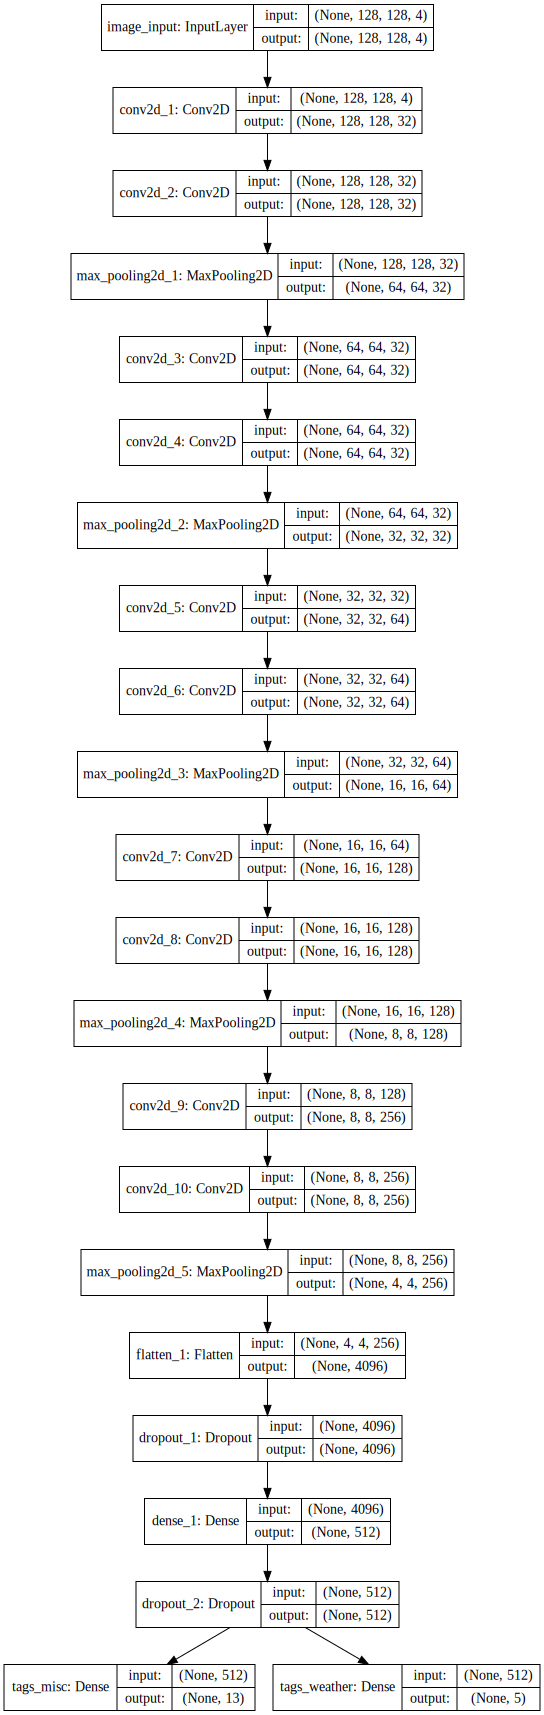

In [11]:
model_as_svg(model)

In [12]:
def random_transform_batch(b):
    for i, img in enumerate(b[0]):
        b[0][i] = random_transform(img, debug=False)
    return b

In [13]:
# data generation

# train_batch_index = -1


def train_generator():
    #     global train_batch_index

#     a = 'T' + str(int(np.random.rand() * 1000))
#     fn = '/tmp/gen-' + a

    while True:

        train_batch_index = np.random.randint(
            TRAIN_SAMPLES_PER_EPOCH / TRAIN_BATCH_SIZE)

#         with open(fn, 'w') as f:
#             f.write(str(train_batch_index))

        b = generate_batch(
            n_samples=TRAIN_BATCH_SIZE,
            batch_index=train_batch_index,
            X_files=X_files_train,
            Y_tags_misc=Y_tags_misc_train,
            Y_tags_weather=Y_tags_weather_train,
            images_dir=IMAGES_DIR,
            image_shape=IMAGE_SHAPE)

        b = random_transform_batch(b)

        yield b


# val_batch_index = -1


def val_generator():
    #     global val_batch_index

    while True:
        val_batch_index = np.random.randint(
            VAL_SAMPLES_PER_EPOCH / VAL_BATCH_SIZE)

        b = generate_batch(
            n_samples=VAL_BATCH_SIZE,
            batch_index=val_batch_index,
            X_files=X_files_val,
            Y_tags_misc=Y_tags_misc_val,
            Y_tags_weather=Y_tags_weather_val,
            images_dir=IMAGES_DIR,
            image_shape=IMAGE_SHAPE)

#         b = random_transform_batch(b)

        yield b

In [14]:
model.compile(
    optimizer='adadelta',
    loss={
        'tags_misc': 'binary_crossentropy',
        'tags_weather': 'binary_crossentropy'
    },
    loss_weights={'tags_misc': 1.,
                  'tags_weather': 0.5})

In [ ]:
model.fit_generator(
    train_generator(),
    steps_per_epoch=TRAIN_SAMPLES_PER_EPOCH,
    epochs=TRAIN_EPOCHS,
    verbose=1,
    callbacks=[
        TensorBoard(log_dir=TENSORBOARD_DIR, histogram_freq=0),
        ModelCheckpoint(
                MODEL_CHECKPOINT_DIR + \
                '/e{epoch:02d}-l={loss:.5f}-vl={val_loss:.5f}.h5',
                monitor='val_loss', verbose=0, save_best_only=False,
                save_weights_only=False, mode='auto'
            ),
    ],
    validation_data=val_generator(),
    validation_steps=VAL_SAMPLES_PER_EPOCH,
    class_weight=None,
    max_q_size=40,
    workers=4,
    pickle_safe=True,
    initial_epoch=0)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=100, validation_steps=8096, verbose=1, callbacks=[<keras.ca..., steps_per_epoch=32383, initial_epoch=0, max_queue_size=40, use_multiprocessing=True, validation_data=<generator..., class_weight=None, workers=4)`
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1786: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
 8757/32383 [=======>......................] - ETA: 1501s - loss: 0.2006 - tags_misc_loss: 0.1363 - tags_weather_loss: 0.1287

---